In [1]:
import numpy as np
import pandas as pd

import os, urllib.request, json , sys, tqdm, warnings

import matplotlib.pyplot as plt
plt.style.use('seaborn')

sys.path.append('/'.join(os.getcwd().split('/')[:-1] + ['code']))
import risk_assessment as ra

In [2]:
time_deltas = [pd.to_timedelta(int(years),unit='Y') for years in np.arange(1,8,1)]

In [3]:
buys = [
    {
        'symbol': 'GOOGL',
        'weight': 1
    },
    {
        'symbol': 'AAPL',
        'weight': 1
    }
]

In [4]:
api_input = {
    'name': 'my_strategy',
    'buys': buys,
    'time_deltas': time_deltas
}

In [5]:
histograms_over_time = ra.calculate_risk_histogram_as_function_of_time_weighted(
    buys,
    time_deltas
)

100%|██████████| 7/7 [00:00<00:00, 10.95it/s]


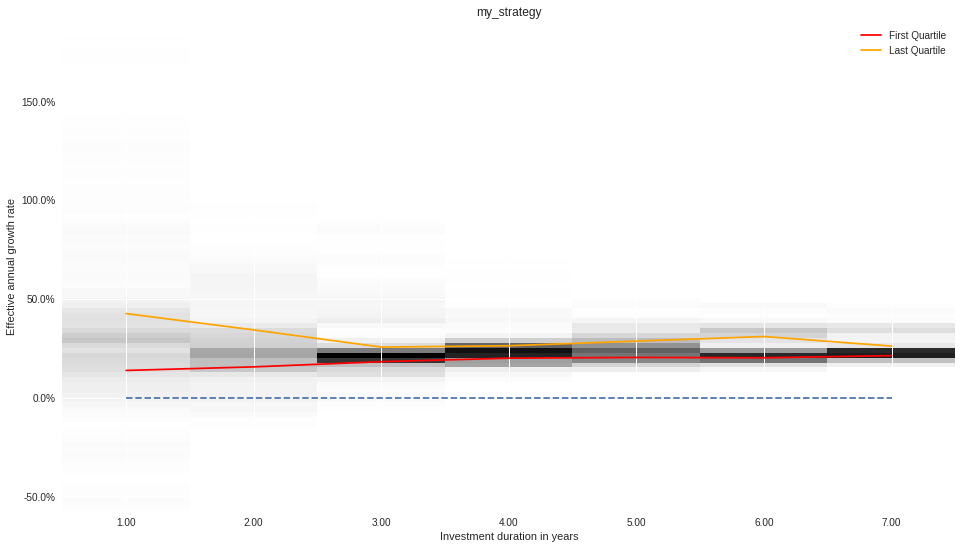

In [6]:
n_bins = 100

fig, ax = plt.subplots(figsize=(16,9))
bins_min = min([np.nanmin(hist) for hist in histograms_over_time])
bins_max = max([np.nanmax(hist) for hist in histograms_over_time])

bins        = np.linspace(bins_min,bins_max,num=n_bins)
bin_centers = (bins[1:] + bins[:-1])/2

binned_over_time = np.zeros((len(bin_centers),len(time_deltas)))
first_quartiles = []
last_quartiles  = []

for ind, [timediff, histogram] in enumerate(zip(time_deltas,histograms_over_time)):
    
#     The distribution and the total number of samples differs for each time_delta,
#     therefore the binning is not done by the default routine but is fixed.
#     This allows to compare statistic relevance by the absolute values of the bin counts
#     that decreases for longer time differences (longer time diff means less samples
#     in fixed time span for which historic data is available)
    
#     create histogram
    [hist_now,_] = np.histogram(histogram,bins)
    binned_over_time[:,ind] = hist_now
                   
#     calculate quartiles
    first_quartiles.append(
        np.percentile(histogram,25)
    )
    last_quartiles.append(
        np.percentile(histogram,75)
    )

    
time_deltas_years = [time_delta.total_seconds()/365/24/60/60 for time_delta in time_deltas]

ax.imshow(
    binned_over_time,
    aspect = 'auto',
    origin='lower',
    extent = [
        time_deltas_years[0] - 0.5,
        time_deltas_years[-1]+ 0.5,
        bins_min,
        bins_max
    ]
)

plt.xticks(
    time_deltas_years,
    ["{:.2f}".format(time_delta) for time_delta in time_deltas_years]
)

ax.set_yticklabels(
    [str(round(100*label)) + '%' for label in ax.get_yticks()]
)

plt.title(api_input['name'])
plt.ylabel('Effective annual growth rate')
plt.xlabel('Investment duration in years')

plt.plot(time_deltas_years,first_quartiles,'red')
plt.plot(time_deltas_years,last_quartiles,'orange')
plt.plot(time_deltas_years,[0] * len(time_deltas_years),'--',)

plt.legend([
    'First Quartile',
    'Last Quartile'
])

plt.savefig('../output/figs/' + api_input['name'] + '.pdf', dpi = 300)
# plt.savefig('../output/figs/' + api_input['name'] + '.jpg', dpi = 300)